# Multiview doubleball extrinsic calibration
Define the balls in different color, and detected using YOLO-v8. If you want to know the full world axes, just use `[2A] single ball + [3] worldaxes_register`

The process is just similar to `[2A] single ball`

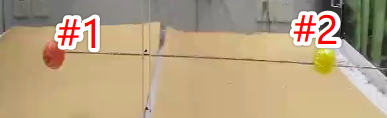

Pre-request, you have run step1 intrinsic calibration. The `intrinsics_calib_frank.json` is previous outcome.

In [1]:
# import the necessary packages
import pickle
import numpy as np
import json

intrinsics_json = 'intrinsics_calib_frank.json'

## The input ball location data format
The ball position in all view is stored in a `keypoints` variable, which is (NVIEW, NSAMPLE, NKEYPOINT=1, XYP=3).

And the `P` in `XYP` is **0<=P<=1**, means the reliable of this detection. If you failed to detect a ball sometimes in a view, just set the `XY=np.nan`, and `P=0` for **IVIEW**. The `P` will be cutoff around `0.7` to auto delete reliable ball detections.

In [2]:
matfile = 'demo_data/OBS_doubleball.matpkl'
matdata = pickle.load(open(matfile, 'rb'))
assert 'keypoints' in matdata.keys()

print(matdata['keypoints'].shape) #(NVIEW, NSAMPLE, NKEYPOINT=3 xyp=3)
print(matdata['info'])            # The grid video. If you video is not grid. Just keep 'nview', 'fps'
print(matdata['views_xywh'])      # (NVIEW, 4) x,y,w,h. If you video is not grid in mycase, you just set x=0,y=0

(9, 953, 2, 3)
{'vfile': '/mnt/liying.cibr.ac.cn_Data_Temp/marmoset_camera3_cxf/2024-7-6-ball/OBS_小球.mp4', 'nview': 9, 'fps': 25.0}
[[0, 0, 640, 480], [640, 0, 640, 480], [1280, 0, 640, 480], [0, 480, 640, 480], [640, 480, 640, 480], [1280, 480, 640, 480], [0, 960, 640, 480], [640, 960, 640, 480], [1280, 960, 640, 480]]


## Create a multiview tree
>Similar to 2A_ball_extrinsic_calib

Here is to set the `connectivity` between cameras. Give the hint which pairs of cameras are likely share/(connectivity) most views field of ball. In general case, all cameras share most common view field. You can use default config. 

For example, `0` share with `2`, `0` not with `1`, `1` share with `2`. You can set `"minimal_tree":{[0, 2], [1, 2]}` to global connection.

Note that this `connectivity` define only works when calibration, and won't affect next step 2D<->3D transfrom.


In [3]:
nview=9
minimal_tree = [[i,i+1] for i in range(nview-1)]
setup_dict = {"views": list(range(nview)),
              "minimal_tree": minimal_tree}
setup_json = 'setup.json'
json.dump(setup_dict, open(setup_json, 'w'), indent=4)
print(setup_dict)

{'views': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'minimal_tree': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]}


## Downsample the ball sample to <=1000
It will do
- Downsample ball sample to 1000
- Pack all nessary informtion into one file

In [4]:
from tripleball_matpkl2ballpkl import convert as convert_matpkl2ballpkl

convert_matpkl2ballpkl(matfile, intrinsics_json, setup_json)

python -m lilab.multiview_scripts_dev.s3_ballpkl2calibpkl demo_data/OBS_doubleball.ballpkl


'demo_data/OBS_doubleball.ballpkl'

## Content of `ballpkl`
- **setup**: copy from `setup.json`
- **intrinsics**: copy from `intrinsic_calib.json`
- **landmarks_move_xy**: downsample ball xy position, (NVIEW, 1000, XY)
- **background_img**: (NVIEW, )x(H,W,3) numpy array for background image each view, default not set
- *landmarks_global_xy*, *landmarks_global_cm*, *global_iframe*: obsoleted


In [5]:
ballpklfile = matfile.replace('.matpkl', '.ballpkl')
ballpkl = pickle.load(open(ballpklfile, 'rb'))
print(ballpkl.keys())
print(ballpkl['landmarks_move_xy'].shape)

dict_keys(['landmarks_global_xy', 'landmarks_move_xy', 'global_iframe', 'landmarks_global_cm', 'background_img', 'setup', 'intrinsics'])
(9, 561, 2)


## !! The most critical setup
## Multiview extrinsic calibration.
The main precessing is :
1. Pair each two pair cameras in the `setup.json/mini_tree`.
2. Concat all views. Get a rough relative pose.
3. Remove outlier samples. Use bundle ajustment to refine relative poses.

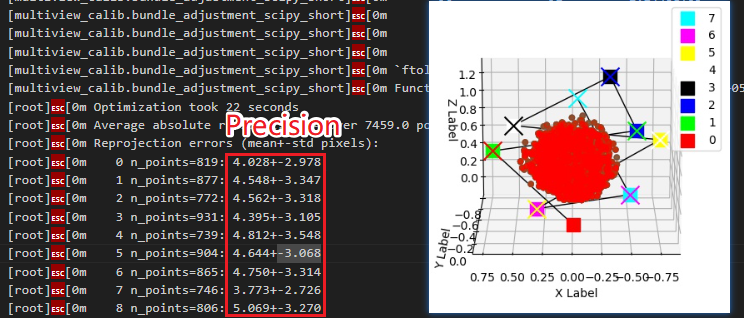

The outcome is `*.calibpkl` file.

In [7]:
from ballpkl2calibpkl import main_calibrate
calibpklfile = main_calibrate(ballpklfile, skip_global=True, skip_camera_intrinsic=True)

2024-09-09 14:44:19,424 [root] -------------------------------------------------
2024-09-09 14:44:19,426 [root] Computing robust relative pose for pair 0->1
2024-09-09 14:44:19,427 [root] Initial relative pose:
2024-09-09 14:44:19,433 [root] Computing relative pose of pair [0, 1]:
2024-09-09 14:44:19,434 [root] 	0 out of 170 points considered outliers.
2024-09-09 14:44:19,437 [root] 	Residual error: 1.2701381628496908
2024-09-09 14:44:19,438 [root] 	Sampson distance: 1.3879634391778433
2024-09-09 14:44:19,439 [root] Number of additional paths found: 5
2024-09-09 14:44:19,444 [root] 	Computing relative pose of pair [0, 2]:
2024-09-09 14:44:19,445 [root] 		0 out of 167 points considered outliers.
2024-09-09 14:44:19,448 [root] 		Residual error: 1.4506189663147715
2024-09-09 14:44:19,449 [root] 		Sampson distance: 1.8613766781163885
2024-09-09 14:44:19,460 [root] 	Computing relative pose of pair [2, 1]:
2024-09-09 14:44:19,462 [root] 		0 out of 437 points considered outliers.
2024-09-09 1

Fixing camera instrincis!
Number of landmarks skipped because only visible in one view: 8


100%|██████████| 561/561 [00:00<00:00, 17194.54it/s]
2024-09-09 14:44:24,156 [root] The preparation of the input data took: 0.14s
2024-09-09 14:44:24,157 [root] Sizes:
2024-09-09 14:44:24,158 [root] 	 camera_params: (9, 15)
2024-09-09 14:44:24,158 [root] 	 points_3d: (553, 3)
2024-09-09 14:44:24,159 [root] 	 points_2d: (3279, 2)


Number of landmarks skipped because only visible in one view: 8


2024-09-09 14:44:24,480 [root] Early Outlier rejection:
2024-09-09 14:44:24,481 [root] 	 threshold outliers: 100
2024-09-09 14:44:24,494 [root] 	 Number of points considered outliers: 3
2024-09-09 14:44:25,036 [multiview_calib.bundle_adjustment_scipy_short]    Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality
2024-09-09 14:44:25,038 [multiview_calib.bundle_adjustment_scipy_short]        0              1         2.9453e+05                                    6.72e+08
2024-09-09 14:44:25,236 [multiview_calib.bundle_adjustment_scipy_short]        1              2         4.4580e+03      2.90e+05       6.31e-01       2.26e+07
2024-09-09 14:44:25,473 [multiview_calib.bundle_adjustment_scipy_short]        2              3         3.7278e+03      7.30e+02       7.55e-02       3.27e+06
2024-09-09 14:44:25,710 [multiview_calib.bundle_adjustment_scipy_short]        3              4         3.6773e+03      5.05e+01       1.62e-01       1.32e+06
2024-09-09 14:44:2

pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
pose keys dict_keys(['K', 'dist', 'R', 't', 'image_shape'])
Number of landmarks skipped because only visible in one view: 8
Skipping global BA
python -m lilab.multiview_scripts_dev.s4_matpkl2matcalibpkl  demo_data/OBS_doubleball.matpkl demo_data/OBS_doubleball.calibpkl


## Content of the outcome `calibpkl` file
- **ba_poses**: all intrinsic & extrinsic parameters. `K` (3, 3), `dist`: (K1_K2_T1_T2_K3,), `t` (3,), `R` (3, 3)

In [8]:
calibpkl = pickle.load(open(calibpklfile, 'rb'))
print(calibpkl.keys())

print('ba_poses', calibpkl['ba_poses'])
calibpkl['ba_poses'][0]

dict_keys(['landmarks_global_xy', 'landmarks_move_xy', 'global_iframe', 'landmarks_global_cm', 'background_img', 'setup', 'intrinsics', 'ba_poses'])
ba_poses {0: {'R': [[1.0, 0.0, 0.0], [0.0, 1.0, 1.2719995431939097e-15], [0.0, -1.2719995431939097e-15, 1.0]], 't': [-0.014724759621689834, 0.027549144152662502, 0.015270844170010728], 'K': [[435.00009990766233, 0.0, 332.9999891645761], [0.0, 581.9999000376529, 235.99994551744885], [0.0, 0.0, 1.0]], 'dist': [-0.37490100391917003, 0.12609958834892696, -9.006331828826331e-05, -9.666196765586661e-05, 9.965801610042788e-05], 'image_shape': [480, 640]}, 1: {'R': [[-0.872994093322875, -0.4624168274204211, -0.15508704246907265], [0.046919055542401944, -0.3961241552231416, 0.9169974132328628], [-0.48546875826399005, 0.7932567877851314, 0.3675102085417965]], 't': [0.1559978339383996, -0.7455242225617331, 0.5921117755618197], 'K': [[461.0000996396713, 0.0, 312.000016938658], [0.0, 615.9999104807496, 235.00000584303322], [0.0, 0.0, 1.0]], 'dist': [-0

{'R': [[1.0, 0.0, 0.0],
  [0.0, 1.0, 1.2719995431939097e-15],
  [0.0, -1.2719995431939097e-15, 1.0]],
 't': [-0.014724759621689834, 0.027549144152662502, 0.015270844170010728],
 'K': [[435.00009990766233, 0.0, 332.9999891645761],
  [0.0, 581.9999000376529, 235.99994551744885],
  [0.0, 0.0, 1.0]],
 'dist': [-0.37490100391917003,
  0.12609958834892696,
  -9.006331828826331e-05,
  -9.666196765586661e-05,
  9.965801610042788e-05],
 'image_shape': [480, 640]}

## Restore scale information
The length between red-ball1 and yello-ball2 is `500mm` in this case. That's restore this scale in `*.calibpkl`

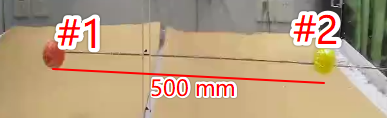

In [9]:
from calibpkl_restore_scale import main as main_rescale
armlen_world = 500.0
recalibpkl = main_rescale(calibpklfile, matfile, armlen_world)

recalibpkl saved as demo_data/OBS_doubleball.recalibpkl


## Next step **[3] world axes registration** and **[4] 2D-3D mutual transformation**.
The **world axes registration** is optional. The doubleball has restore the scale, but not know the origin point and XYZ oritation. If you don't want to do it, just skip it.